In [ ]:
pip install -q statsmodels==0.11.0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Предобработка

Преобразуем данные, как в прошлый раз. Но сейчас сделаем дополнительный столбец, опираясь на данные _"Древесина необработанная, тыс. кубометров"_ из таблицы __3.1 показатели производства (погодовые).xlsx__.

Так как в данные по производству имеют шаг раз в год, а по экспорту раз в месяц, нужно привести всё к одному виду. Чтобы не терять существующие данные по экспорту, будем записывать на каждый год 12 одинаковых значений по производству.

In [ ]:
df = pd.read_excel('data/4.2 лесные перевозки.xlsx', index_col='Месяц').transpose()
df.index = pd.to_datetime(df.index, format="%Y/%m")
df = df.drop(['Вид перевозки'], axis=1)

df['Внутр. перевозки'] = df['Внутр. перевозки'].shift(1)
df['Импорт'] = df['Импорт'].shift(1)
df['Транзит'] = df['Транзит'].shift(1)

df = df.iloc[1:]
df = df.astype(int)
df = df.asfreq('MS')

df_tmp = pd.read_excel('data/3.1 показатели производства (погодовые).xlsx', skiprows=2, 
                    usecols=range(1, 14), index_col='Unnamed: 1')
df_tmp = df_tmp.dropna()
df_tmp = df_tmp.transpose()

production = df_tmp['Древесина необработанная, тыс. кубометров']
df['Производство'] = [production[x.year - 1] if (x.year - 1) in df_tmp.index else None for x in df.index]

df = df.loc['2009':]

df.head(3)

Месяц,Внутр. перевозки,Экспорт,Импорт,Транзит,Производство
2009-01-01,1694047,1018906,49290,111695,108204.9
2009-02-01,1585617,1486894,21050,43256,108204.9
2009-03-01,1623911,2363698,23123,39875,108204.9


## Разделение данных

Разделим данные на тестовую и тренировочную выборки

In [ ]:
train_size = int(df.shape[0] * 0.8)
df_train = df.iloc[:train_size]
df_test  = df.iloc[train_size:]
print(f'В тренировочной выборке находится {train_size} элементов')

В тренировочной выборке находится 96 элементов


## Построение модели без учета производства

В прошлый раз при построении модели я допустил ошибку, из-за чего каждая модель проводила дополнительное дифференцирование. Поэтому, для начала посмотрим на правильно построенную модель.

Наилучшим образом данные (без учета данным по производству) описывает модель __SARIMAX(1, 0, 3)x(1, 1, 1, 12)__

In [ ]:
exog = df_train.loc[:, ['Внутр. перевозки', 'Импорт', 'Транзит']]

model = sm.tsa.arima.ARIMA(df_train.Экспорт, order=(1, 0, 3), seasonal_order=(1, 1, 1, 12), exog=exog).fit()

## Оценка модели без учета производства

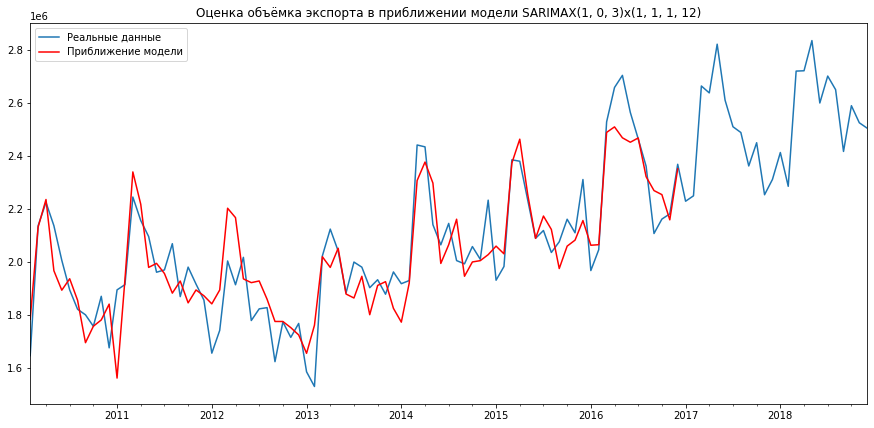

In [ ]:
plt.figure(figsize=(15,7))
df.Экспорт[13:].plot()
model.fittedvalues[13:].plot(color='r')
plt.legend(['Реальные данные', 'Приближение модели'])
plt.title('Оценка объёмка экспорта в приближении модели SARIMAX(1, 0, 3)x(1, 1, 1, 12)')
plt.show()

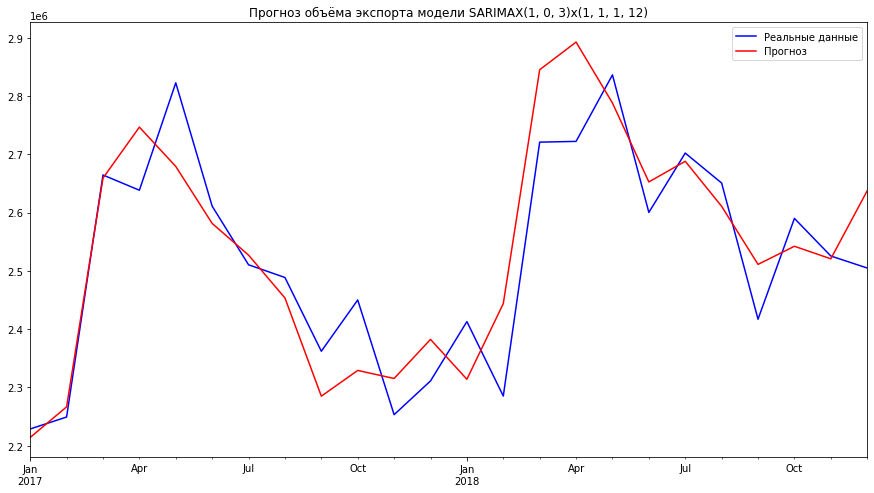

MSE: 7483264581 тонн
MAE: 70302 тонн
R2:  0.7631


In [ ]:
y_pred = model.predict(start=df_test.index.min(), end=df_test.index.max(), 
                            exog=df_test.loc[:, ['Внутр. перевозки', 'Импорт', 'Транзит']]) 

plt.figure(figsize=[15, 8])
df_test.Экспорт.plot(c='b')
y_pred.plot(c='r')
plt.legend(['Реальные данные', 'Прогноз'])
plt.title('Прогноз объёма экспорта модели SARIMAX(1, 0, 3)x(1, 1, 1, 12)')
plt.show()

print(f'MSE: {mean_squared_error(df_test.Экспорт, y_pred):.0f} тонн')
print(f'MAE: {mean_absolute_error(df_test.Экспорт, y_pred):.0f} тонн')
print(f'R2:  {r2_score(df_test.Экспорт, y_pred):.4f}')

По сравнению с предыдущим результатом средняя абсолютная ошибка снизилась на 10000 тонн.

## Построение модели с учетом объёма производства

Используем модель __SARIMAX(1, 0, 3)x(0, 1, 1, 12)__

In [ ]:
exog = df_train.loc[:, df.columns != 'Экспорт']

model = sm.tsa.arima.ARIMA(df_train.Экспорт, order=(1, 0, 3), seasonal_order=(0, 1, 1, 12), exog=exog).fit()

## Оценка модели c учетом объёма производства

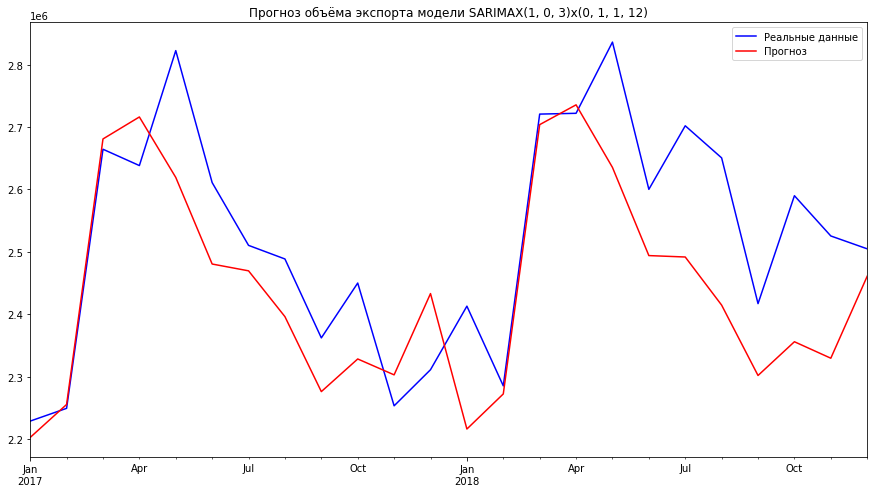

MSE: 17261022649 тонн
MAE: 106466 тонн
R2:  0.4535


In [ ]:
y_pred = model.predict(start=df_test.index.min(), end=df_test.index.max(), 
                            exog=df_test.loc[:, df.columns != 'Экспорт']) 

plt.figure(figsize=[15, 8])
df_test.Экспорт.plot(c='b')
y_pred.plot(c='r')
plt.legend(['Реальные данные', 'Прогноз'])
plt.title('Прогноз объёма экспорта модели SARIMAX(1, 0, 3)x(0, 1, 1, 12)')
plt.show()

print(f'MSE: {mean_squared_error(df_test.Экспорт, y_pred):.0f} тонн')
print(f'MAE: {mean_absolute_error(df_test.Экспорт, y_pred):.0f} тонн')
print(f'R2:  {r2_score(df_test.Экспорт, y_pred):.4f}')

Прогноз всё ещё похож на реальные данные. Однако, метрики оценки показывают ухудшение качества предсказания.

Поробуем разобраться, в таком поведении данных. Построим графики экспорта и производства.

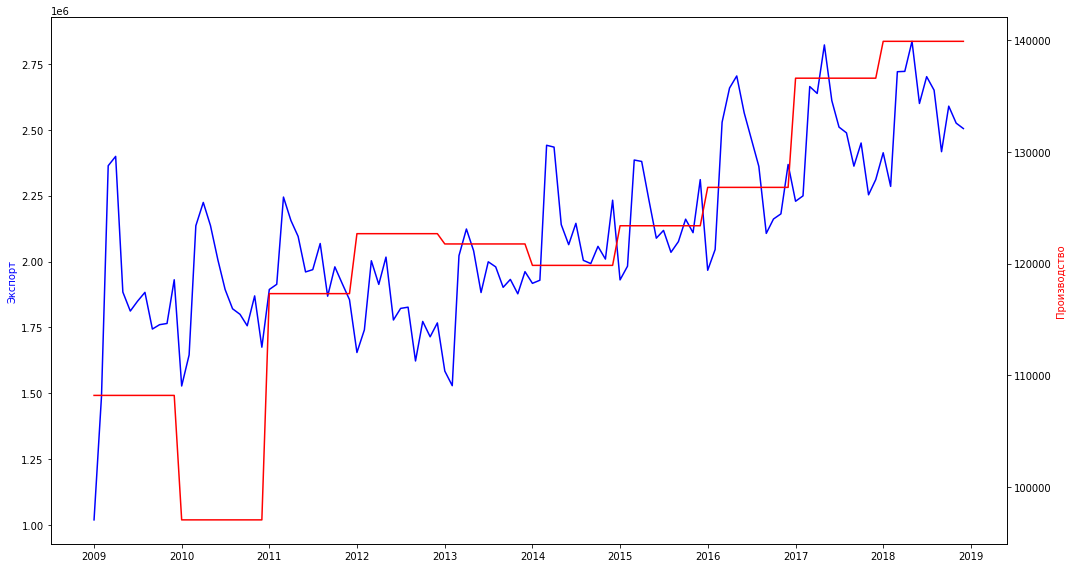

In [ ]:
fig, ax1 = plt.subplots(figsize=[15, 8])
ax1.set_ylabel('Экспорт', color='b')
ax1.plot(df['Экспорт'], color='b')

ax2 = ax1.twinx()
ax2.set_ylabel('Производство', color='r')
ax2.plot(df['Производство'], color='r')

fig.tight_layout()
plt.show()

Возможные причины отстутствия корреляции между производством и экспортом:
 - С 2010 по 2011 года был сильный выброс - производство было сильно занижено, в то время как снижения экспорт не наблюдалось.
 - Аналогичная ситуация с 2012-2013 годом. Производство было повышено, а экспорт наоборот.
 - Данных мало. В таблице по экспорту после отбора находится 120 измерений, а в таблице по производству всего 11. Такого количества может быть просто недостаточно, для поиска и автокорреляции, и корреляции двух рядов.
 - Разный масштаб. Данные по производству дублируются 12 раз. По всей видимости, это привносит некоторые шумы.